#### Regression coefficient analysis

In [28]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle
import glob
import pathlib
from pathlib import Path
import re 
import sys
from pynwb import NWBHDF5IO
import shutil
import time
from IPython.display import display, HTML

sys.path.insert(1, '/root/capsule/code/utils')
import behavior_utils as bu
import array_utils as au


import joblib
from joblib import Memory

file_path = '/root/capsule/data/foraging_nwb_bonsai_processed/662914_2023-09-22/662914_2023-09-22_df_session_logistic_regression_df_beta_Su2022.pkl'

In [29]:
with open(file_path, 'rb') as file:
    data = pickle.load(file)
print(data.shape)

(1, 31)


In [30]:
# Load in session DataFrame
folder = '/root/capsule/data/filtered_data_session/filtered_data_20241107.csv'
session_df = pd.read_csv(folder)

/tmp/ipykernel_10049/2073535739.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  session_df = pd.read_csv(folder)


In [31]:
print(data.info())
print(data.index.names)
print(data.columns.names)

for name in data.index.names:
    print(f"Unique values in {name}:", data.index.get_level_values(name).unique())

for name in data.columns.names:
    print(f"Unique values in {name}:", data.columns.get_level_values(name).unique())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1 entries, ('662914', '2023-09-22', 0) to ('662914', '2023-09-22', 0)
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   (RewC, 15.0)  1 non-null      float64
 1   (RewC, 14.0)  1 non-null      float64
 2   (RewC, 13.0)  1 non-null      float64
 3   (RewC, 12.0)  1 non-null      float64
 4   (RewC, 11.0)  1 non-null      float64
 5   (RewC, 10.0)  1 non-null      float64
 6   (RewC, 9.0)   1 non-null      float64
 7   (RewC, 8.0)   1 non-null      float64
 8   (RewC, 7.0)   1 non-null      float64
 9   (RewC, 6.0)   1 non-null      float64
 10  (RewC, 5.0)   1 non-null      float64
 11  (RewC, 4.0)   1 non-null      float64
 12  (RewC, 3.0)   1 non-null      float64
 13  (RewC, 2.0)   1 non-null      float64
 14  (RewC, 1.0)   1 non-null      float64
 15  (UnrC, 15.0)  1 non-null      float64
 16  (UnrC, 14.0)  1 non-null      float64
 17  (UnrC, 13.0)  1 non-null 

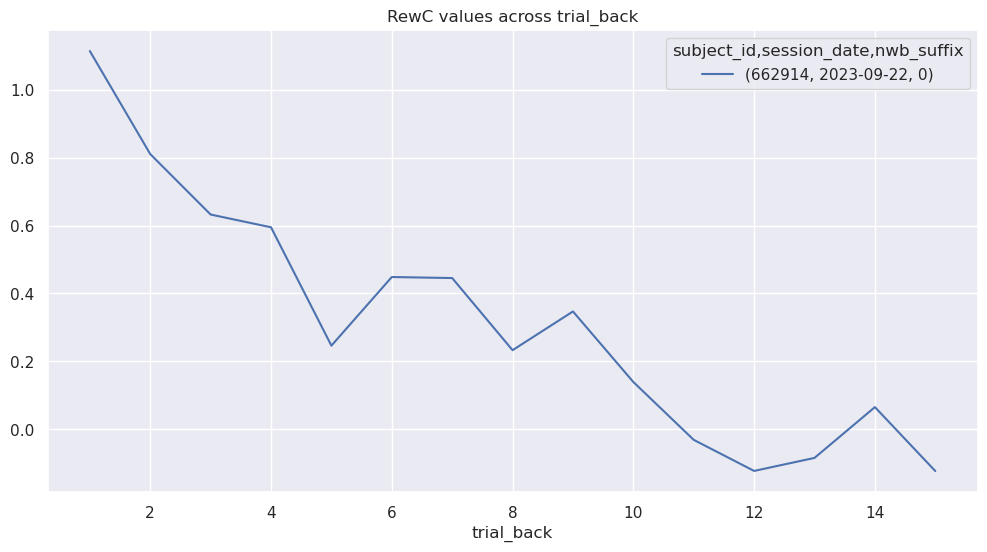

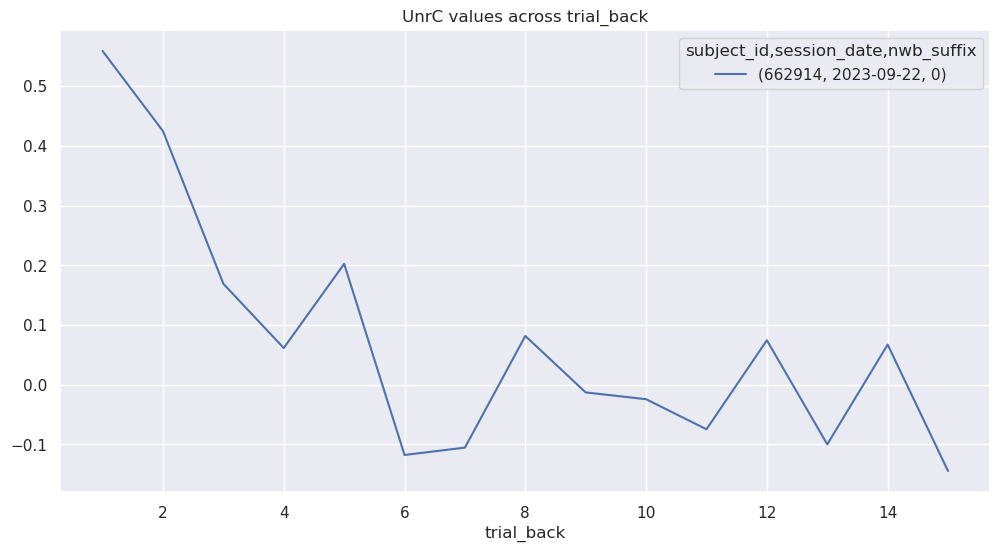

In [32]:

sns.set_theme()

# Plot Rewarded Choice
data['RewC'].T.plot(figsize=(12, 6))
plt.title('RewC values across trial_back')
plt.show()

# Plot Unrewarded Choice
data['UnrC'].T.plot(figsize=(12, 6))
plt.title('UnrC values across trial_back')
plt.show()

In [33]:
# folder = '/root/capsule/scratch'
# for filename in os.listdir(folder):
#     file_path = os.path.join(folder, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))

In [34]:
cachedir = '/root/capsule/scratch'
memory = Memory(cachedir, verbose=0)

@memory.cache
def process_single_dataset(pkl_file_path): 
    """ 
    Process single pkl dataset and extract values

    Params:
    pkl_file_path (str or Path): Path to the pkl file 
    """ 
    try:
        # Load pkl and extract values
        with open(pkl_file_path, 'rb') as file:
            df = pickle.load(file) 

        rewc_values = {}
        unrc_values = {}

        for trial_back in range(1,16):
            rewc_values[trial_back] = df[('RewC', trial_back)].iloc[0]
            unrc_values[trial_back] = df[('UnrC', trial_back)].iloc[0]

        results_df = pd.DataFrame({
            'trial_back': range(1,16),
            'RewC': [rewc_values[i] for i in range(1,16)],
            'UnrC': [unrc_values[i] for i in range(1,16)]
        })

        # Get subject_id and session_date
        parts = pkl_file_path.stem.split('_')
        subject_id = parts[0]
        session_date = parts[1]

        # Save extracted values to output directory
        output_file = Path('/root/capsule/scratch') / f'{subject_id}_{session_date}.csv'
        results_df.to_csv(output_file, index=False)
        print(f'Successfully processed: {pkl_file_path.name}')

    except (KeyError, IndexError) as e:
        print(f'Error processing: {pkl_file_path.name}: {str(e)}')

In [35]:
base_dir = Path('/root/capsule/data/foraging_nwb_bonsai_processed')
pkl_files = [f for f in base_dir.glob('*/*_df_session_logistic_regression_df_beta_Su2022.pkl') if f.is_file()]

for pkl_file in pkl_files:
    process_single_dataset(pkl_file)

In [36]:
# Filename metadata extraction 

def extract_metadata_from_filename(file_path): 
    filename = file_path.split('/')[-1]
    subject_id, session_date = filename.split('_')[:2]
    return subject_id, session_date

In [37]:
# Create master DataFrame

correct_pattern = re.compile(r'^\d{6}(_\d{4}-\d{2}-\d{2})\.csv$')
incorrect_pattern = re.compile(r'_\w+\.csv$')

csv_files = glob.glob('/root/capsule/scratch/*.csv')

dataframes = []

for file in csv_files:
    filename = file.split('/')[-1]

    if not correct_pattern.match(filename) or incorrect_pattern.search(filename):
        continue
    
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove special characters

    # Extract subject_id, session_date from metadata 
    subject_id, session_date = extract_metadata_from_filename(file)

    # Add metatdata columns
    df['subject_id'] = subject_id
    df['session_date'] = session_date
    
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['subject_id'] = pd.to_numeric(combined_df['subject_id'], errors='coerce')


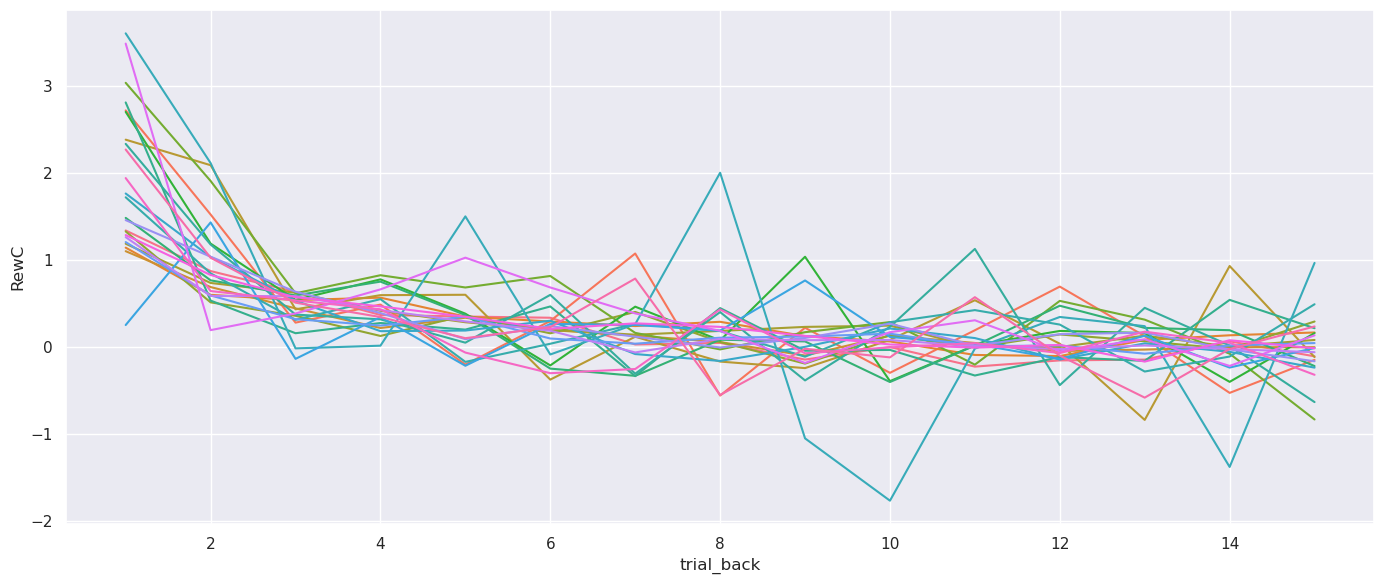

In [38]:
unique_id = 744779

test_df = combined_df[combined_df['subject_id'] == unique_id]

plt.figure(figsize=(14,6))
s = sns.lineplot(data=test_df, x='trial_back', y='RewC', hue='session_date', legend=False)
plt.tight_layout()
plt.show()

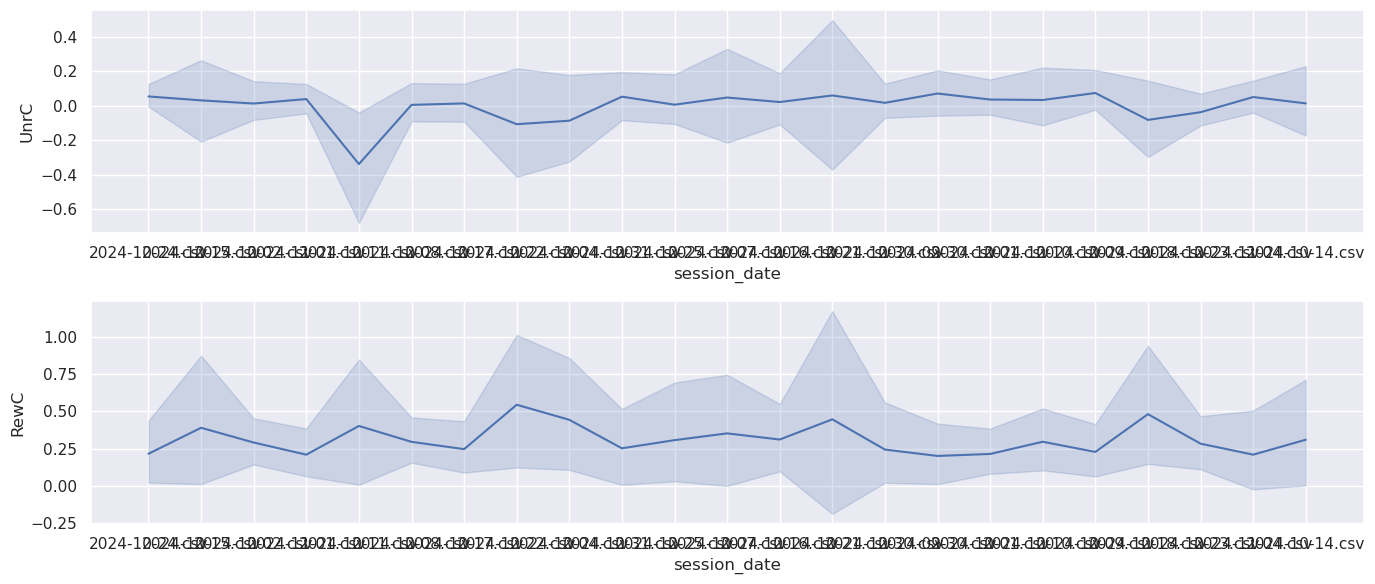

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))

sns.lineplot(data=test_df, x='session_date', y='UnrC', ax=ax1)

sns.lineplot(data=test_df, x='session_date', y='RewC', ax=ax2)

plt.tight_layout()
plt.show()

In [40]:
# Regression slope calculation 

def calculate_slope(df, trial_back_n):
    """ 
    Calculate slope of regression line for first n trial_back values for each subject_id session_date pair

    Params: 
    df (DataFrame): Input regression coefficient DataFrame with RewC and UnrC beta coefficient values 
    trial_back_n (int): Number of past trials to be included in regression 

    Returns:
    result_df (DataFrame): DataFrame with subject_id, session_date, and slope columns 
    """ 

    # Initialize results 
    results = []

    # Group by subject and session date
    grouped = df.groupby(['subject_id', 'session_date'])

    for (subject_id, session_date), group in grouped:
        group = group.sort_values(by='trial_back')

        first_n = group.head(trial_back_n)

        if len(first_n) < trial_back_n: 
            continue

        # Extract trial back and coefficient values
        x = first_n['trial_back']

        # Calculate slope for RewC
        y_rewc = first_n['RewC']
        slope_rewc = np.polyfit(x, y_rewc, 1)[0]

        # Calculate slope for RewC
        y_unrc = first_n['UnrC']
        slope_unrc = np.polyfit(x, y_unrc, 1)[0]

        results.append({
            'subject_id': subject_id,
            'session_date': session_date,
            'slope_RewC': slope_rewc,
            'slope_UnrC': slope_unrc
        })

    result_df = pd.DataFrame(results)
    return result_df

In [41]:
slope_df = calculate_slope(combined_df, trial_back_n = 2)

slope_df

,subject_id,session_date,slope_RewC,slope_UnrC
0,662914,2023-09-19.csv,-0.651586,-0.507835
1,662914,2023-09-21.csv,-1.853889,-0.701837
2,662914,2023-09-22.csv,-0.303175,-0.134120
3,662914,2023-09-25.csv,-1.161310,-0.705931
4,662914,2023-09-29.csv,-0.979688,-0.414583
...,...,...,...,...
5352,769887,2024-11-06.csv,0.004976,-0.168317
5353,769888,2024-11-04.csv,0.348915,0.112820
5354,769888,2024-11-07.csv,-1.671448,-0.399860
5355,769888,2024-11-08.csv,-0.001002,-0.001097


In [50]:
slope_df['subject_id'] = pd.to_numeric(slope_df['subject_id'], errors='coerce')
session_df['subject_id'] = pd.to_numeric(df['subject_id'], errors='coerce')

print(slope_df.dtypes)
print(df.dtypes)

subject_id        int64
session_date     object
slope_RewC      float64
slope_UnrC      float64
dtype: object
trial_back        int64
RewC            float64
UnrC            float64
subject_id        int64
session_date     object
dtype: object


In [51]:
session_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,subject_genotype,fiber_probes,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status
0,668551.0,2024-11-06,173429,31.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,wt/wt,[],[],Uncoupled Baiting,[],[],behavior_743794_2024-11-06_17-34-29_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/5...,17-34-29,2_uploaded and processed
1,668551.0,2024-11-06,173034,35.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,wt/wt,[],[],Uncoupled Baiting,[],[],behavior_741210_2024-11-06_17-30-34_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/b...,17-30-34,2_uploaded and processed
2,668551.0,2024-11-06,172930,31.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9),[],[],Uncoupled Baiting,[],[],behavior_728568_2024-11-06_17-29-30_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/1...,17-29-30,2_uploaded and processed
3,668551.0,2024-11-06,172625,11.0,447-1-D,Bowen Tan,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,[],[],Uncoupled Baiting,[],[],behavior_745505_2024-11-06_17-26-25_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/d...,17-26-25,2_uploaded and processed
4,668551.0,2024-11-06,172512,15.0,447-1-C,Bowen Tan,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,[],[],Uncoupled Baiting,[],[],behavior_745502_2024-11-06_17-25-12_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/9...,17-25-12,2_uploaded and processed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9078,NaN,2019-06-26,164352,2.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9079,NaN,2019-06-25,213144,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9080,NaN,2019-06-25,201839,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9081,NaN,2019-06-25,190736,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded


In [52]:
master = bu.merge_dataframes_subject_id(session_df, slope_df)

In [53]:
master

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status,slope_RewC,slope_UnrC


In [46]:
test_slope_df = master[master['subject_id'] == unique_id]

test_slope_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status,slope_RewC,slope_UnrC


<Axes: xlabel='session', ylabel='slope_RewC'>

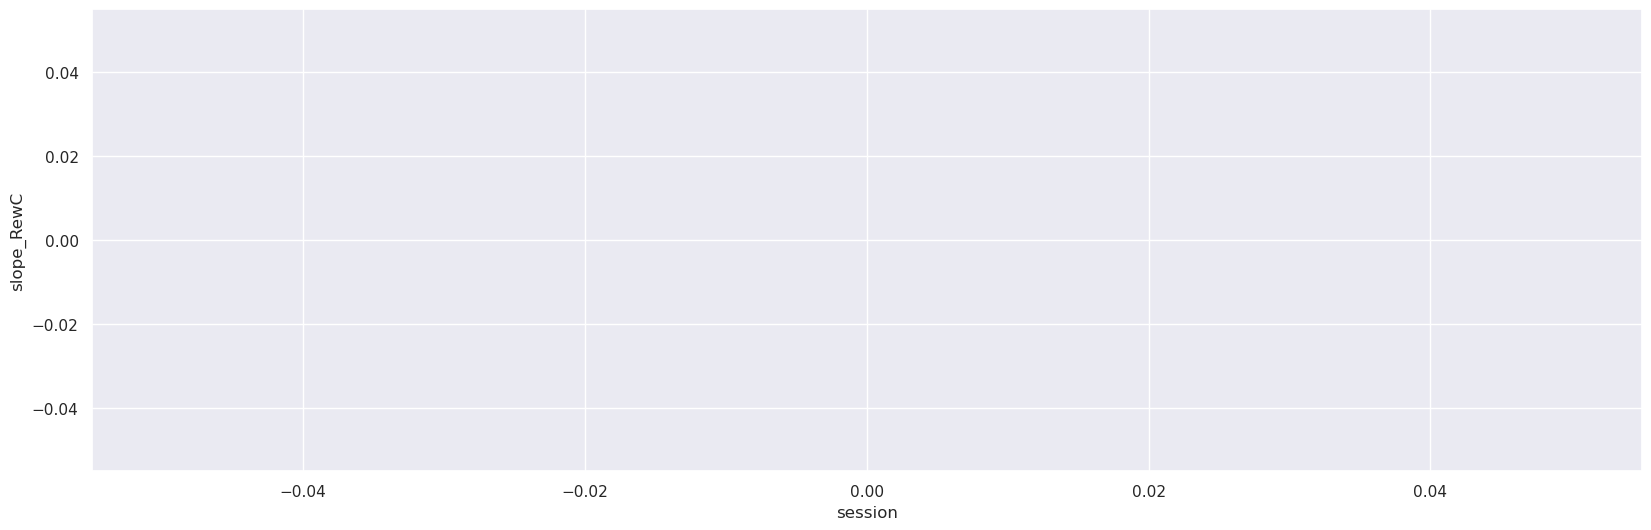

In [47]:
plt.figure(figsize=(20,6))
sns.lineplot(test_slope_df, x='session', y='slope_RewC')
sns.scatterplot(test_slope_df, x='session', y='slope_RewC', s=1)

In [48]:
# Loop through parameters find optimal solution 